In [1]:
from collections import namedtuple
import numpy.random as rd
import tensorflow.compat.v1 as tf
from tensorflow.python.ops.variables import Variable

import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings("ignore",category=FutureWarning)
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.disable_v2_behavior()

import numpy as np
import random
import matplotlib.pyplot as plt 
%matplotlib notebook
%matplotlib inline 

In [16]:

#####################################################################################
class LMU_delay():
    
    def __init__(self, seed, dt, batch, delay, dim, t_train, t_test, n_in, n_rec, n_out, \
                 tau_recsyn, tau_postsyn, neuronParam, intercept, rate, propertyList, inputFreq, plotFlag):
        
        self.seed = seed
        self.batch = batch
        self.dt = dt
        self.delay = delay
        self.dim = dim
        self.t_train = t_train
        self.t_test = t_test
        self.plotFlag = plotFlag
        
        self.intercept = intercept
        self.rate = rate  
        self.L1n = 0.1 #L1 norm for ridge regression
        self.sim_out = 0
        
        self.n_in = n_in
        self.n_rec = n_rec
        self.n_out = n_out
        self.tau_recsyn = tau_recsyn
        self.tau_postsyn = tau_postsyn
        self.neuron_param = neuronParam
        self.propertyList = propertyList
        
        import nengo
        model = nengo.Network()
        with model:
            stim=nengo.Node(nengo.processes.WhiteSignal(period=10, high=inputFreq, seed=0))
            signal = nengo.Probe(stim)   
        with nengo.Simulator(model) as sim:
            sim.run(20.0)    
        self.sim_data=sim.data[signal]
    
    ############# input #############################################################
    def inputFunction(self, t):   
        self.sim_out=self.sim_data[int(t)][0]*0.6
        return self.sim_out

    ############# initial neuron model and network #################################
    def initialNeuron(self, inW, inBias, recW, outW):
        
        network_param = [self.n_in, self.n_rec, self.n_out]  
        synapse_param = [self.tau_recsyn, self.tau_postsyn, inW, inBias, recW, outW]  
        cell = ALIF(network_param, self.neuron_param, synapse_param)
        
        return cell
    
    ############# LMU function ####################################################
    def LDN(self):
        from scipy.special import legendre
        from scipy import linalg
        
        Q = np.arange(self.dim, dtype=np.float32)
        R = (2*Q + 1)[:, None] / self.delay
        j, i = np.meshgrid(Q, Q)
        A = np.where(i < j, -1, (-1.)**(i-j+1)) * R 
        B = (-1.)**Q[:, None] * R 
    
        m = np.asarray([legendre(i)(2*1 - 1) for i in range(self.dim)])
        Wm = m.reshape(self.dim, -1).T
    
        #discretize
        dA = linalg.expm(A*self.dt)
        dB = np.dot(np.dot(np.linalg.inv(A), (dA-np.eye(self.dim))), B)
        return A, B, Wm, dA, dB

    def step_legendre(self, t, state, dA, dB):
        state[:] = np.dot(dA, state) + np.dot(dB, [[t]])
        return state
    
    ############# Generate training set to calculalte decoder ###############
    def generateInput_train(self):
  
        ldn=self.LDN() 
        sample=[]
        state = np.zeros((self.dim, 1))
        t=0
        while t < self.t_train:
            state=self.step_legendre(self.inputFunction(t/self.dt), state, ldn[3], ldn[4])
            sample.append(state.T.flatten())
    
            t+=self.dt 
        sample=np.array(sample)
        return sample
    
    ############# Testing set ####################################################
    def generateInput_test(self):
    
        t=0
        sample=[]
        while t < self.t_test: 
            x = self.inputFunction(t/self.dt)   
            sample.append(x)
            t += self.dt
        sample=np.array(sample)
        return sample
    
    ############# Functions to generate gain, bias, encoder #################
    def compute_encoder(self):
        np.random.seed(self.seed)
        encoder = np.random.randn(self.n_rec, self.dim)
        encoder /= np.sqrt(np.sum(np.asarray(encoder) ** 2, axis=1, keepdims=True))       
        return encoder

    def generate_gain_and_bias(self):
        gain = []
        bias = []
        
        import bisect
        for i in range(self.n_rec):
            # desired intercept (x value for which the neuron starts firing
            random.seed(self.seed+i)
            intercept = random.uniform(self.intercept[0], self.intercept[1])
            
            # desired maximum rate (firing rate when x is maximum)
            random.seed(self.seed+i)
            rate = random.uniform(self.rate[0], self.rate[1]) 
            rate = min(self.propertyList[-1], rate)
            
            interceptIndex = bisect.bisect(self.propertyList, 1)-1
            maxFreqIndex = bisect.bisect(self.propertyList, rate)-1
            
            interceptCurrent = self.propertyList[interceptIndex]*50 #when spike just happens, rate=1
            maxCurrent = self.propertyList[maxFreqIndex]*50 #randomly set a max rate between rate_low and rate_high
            
            # calculate gain and bias
            A=np.array([[intercept, 1], [1, 1]]).T
            B=np.array([interceptCurrent, maxCurrent]).T
            result = np.linalg.solve(A, B)
            gain.append(round(result[0],1))
            bias.append(round(result[1],1))
        return gain, bias
    
    ############# Calculate decoder ##############################################
    def calculate_decoder(self, inW, inBias, recW, outW):
                    
        # 6-dimensional inputs
        sample = self.generateInput_train()
        time_step=len(sample)
        
        #initial
        cell=self.initialNeuron(inW, inBias, recW, outW)
       
        inputs = tf.placeholder(tf.float32, [self.batch, time_step, self.dim], name='inputs')
        init_state = cell.zero_state(self.batch, tf.float32)
        rnn_out, states = tf.nn.dynamic_rnn(cell, inputs, initial_state=init_state)
             
        #run
        session = tf.Session()
        session.run(tf.global_variables_initializer())
        
        in_current=np.reshape(sample, (self.batch, time_step, self.dim) )
        out = session.run([rnn_out], feed_dict={inputs: in_current})
        out = out[0]   # [u, s, w, Istilumi, Isyn, out], dim, timestep, neuron
    
        # calculate decoder
        from sklearn import linear_model
        import nengo

        spike=out[1][0]
       
        filt = nengo.synapses.Lowpass(0.1)
        reg = linear_model.Ridge(alpha=self.L1n, fit_intercept=False)
        reg.fit(filt.filt(spike), filt.filt(sample))
    
        decoder=reg.coef_  
    
        return decoder
    
    ############# Plot tuning curve #################################################
    def tuningCruve(self, inW, inBias, recW, outW, plotFlag=1):
        
        time_step=1000 
        
        spikeFreq=[]
        inputList=[]
        # 6-dimensional inputs, swap between -1 and 1
        for i in range(0, 200, 10):
            x_in=float(i/100)-1
            sample = np.ones([time_step, self.dim])*x_in
        
            #initial
            cell=self.initialNeuron(inW, inBias, recW, outW)
       
            inputs = tf.placeholder(tf.float32, [self.batch, time_step, self.dim], name='inputs')
            init_state = cell.zero_state(self.batch, tf.float32)
            rnn_out, states = tf.nn.dynamic_rnn(cell, inputs, initial_state=init_state)
             
            #run
            session = tf.Session()
            session.run(tf.global_variables_initializer())
        
            in_current=np.reshape(sample, (self.batch, time_step, self.dim) )
            out = session.run([rnn_out], feed_dict={inputs: in_current})
            out = out[0]   # [u, s, w, Istilumi, Isyn, out], dim, timestep, neuron
            
            spikeFreq.append(sum(out[1][0]))
            inputList.append(x_in)
        
        if plotFlag:
            plt.figure(figsize=(10, 4))
        
            plt.plot(inputList, spikeFreq)
            plt.xlabel('time (ms)', size=15)
            plt.ylabel('membrane potential (mV)', size=15)

            plt.show()                   
        
    ############# Calculate weights ###############################################
    def getWeights(self):
        
        ######### Indentity function, calculate decoder ########
        encoder = self.compute_encoder()
        gain, bias = self.generate_gain_and_bias() 
        
        inW = encoder.T*gain
        inBias = np.reshape(bias, (1,-1))
        recW = np.zeros([self.n_rec, self.n_rec])
        outW = np.ones([self.n_rec, self.n_out])
        
        #self.tuningCruve(inW, inBias, recW, outW)
        decoder = self.calculate_decoder(inW, inBias, recW, outW)
        tau = 0.1
        
        ######### Delay function ################################    
        A, B, Wm,_,_ = self.LDN()
        W_in = np.dot(inW.T, B*tau).T
        W_rec = np.dot(np.dot(inW.T, A*tau+np.eye(self.dim)), decoder).T
        W_out = np.dot(Wm, decoder).T
        W_bias = inBias
        
        return W_in, W_bias, W_rec, W_out
    
    ############# Calculate delay ##############################################
    def calculate_delay(self, W_in, W_bias, W_rec, W_out):
                    
        # 1-dimensional inputs
        sample = self.generateInput_test()
        time_step=len(sample)
        dim = 1
    
        # initial
        cell=self.initialNeuron(W_in, W_bias, W_rec, W_out)
        
        inputs = tf.placeholder(tf.float32, [self.batch, time_step, dim], name='inputs')
        init_state = cell.zero_state(self.batch, tf.float32)
        rnn_out, states = tf.nn.dynamic_rnn(cell, inputs, initial_state=init_state)
             
        #run
        session = tf.Session()
        session.run(tf.global_variables_initializer())
        
        in_current=np.reshape(sample, (self.batch, time_step, dim) )
        out = session.run([rnn_out], feed_dict={inputs: in_current})
        out = out[0]   # [u, s, w, Istilumi, Isyn, out], dim, timestep, neuron
    
        # get predicted result
        spike = out[1][0]
        result = out[5][0].T[0].T
    
        # calculate mse
        ideal = np.zeros(len(in_current[0]))
        ideal[int(self.delay/self.dt):] = sample[0:-int(self.delay/self.dt)]
     
        # plot the result
        if self.plotFlag:
            from numpy import mat
            plt.figure(figsize=(12,3))
            data=mat(spike).nonzero()
            #np.savetxt("ALIF_freq1.txt", data)
            plt.scatter(data[0], data[1], s=1, c='navy', alpha=0.05)
            plt.title("Spiking Pattern for ALL Neuron")
            plt.yticks(size=12)
            plt.xticks(size=12)
            plt.show()

            plt.figure(figsize=(12,3))
            plt.plot(result)
            plt.plot(sample)
            plt.plot(ideal)
            plt.yticks(np.arange(-1, 1.5, 0.5), size=12)
            plt.xticks(size=12)
            plt.show()
    
        # return value
        mse = ((ideal-result)**2).mean(axis=0)
        avgSpikeFreq=round(np.sum(np.sum(spike, axis=0)),1)/(self.n_rec*self.t_test)
    
        return mse, avgSpikeFreq                             
                              
    ############# Different learning appraoches #####################################
    def delay_functions(self):
                              
        W_in, W_bias, W_rec, W_out = self.getWeights()                  
        mse, avgSpikeFreq = self.calculate_delay(W_in, W_bias, W_rec, W_out)
        return round(mse, 5), round(avgSpikeFreq, 2)

In [7]:
def getProperty(neuron_param, ALIF, showLen, showCur, plotFlag):
    time_step = showLen #(1s)
    n_batch = 1
    dim = 1
        
    spikeFreq, voltageList, currentList=[], [], []
    
    #initial
    n_in, n_rec, n_out = 1, 1, 1   
    inW=np.ones([n_in, n_rec]) 
    inBias=np.zeros([n_in, n_rec])
    recW=np.zeros([n_rec, n_rec])
    outW = np.zeros([n_rec, n_out])
    synapse_param = [100, 100, inW, inBias, recW, outW]
    network_param = [n_in, n_rec, n_out]
    cell = ALIF(network_param, neuron_param, synapse_param)   
    
    inputs = tf.placeholder(tf.float32, [n_batch, time_step, dim], name='inputs')
    init_state = cell.zero_state(n_batch, tf.float32)
    rnn_out, states = tf.nn.dynamic_rnn(cell, inputs, initial_state=init_state)
             
    #run
    session = tf.Session()
    session.run(tf.global_variables_initializer())
        
    for current in range(0, 10000, 50): #accumulated current range
        sample=np.reshape(np.ones(time_step)*current, (1, -1))

        in_current=np.reshape(sample, (n_batch, time_step, dim) )
        out = session.run([rnn_out], feed_dict={inputs: in_current})
        out = np.array(out[0])  # [u, s, w, Istilumi, Isyn, out], dim, timestep, neuron
        
        voltageList.append(out[0][0].T[0])
        spikeFreq.append(sum(out[1][0].T[0]))
        currentList.append(current)
            
    if plotFlag:
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1,2,1)
        neuronNum=showCur
        plt.plot(np.arange(time_step), voltageList[neuronNum])
        plt.xlabel('time (ms)', size=15)
        plt.ylabel('membrane potential (mV)', size=15)
        plt.title('accumulated input current '+str(showCur*50)+' pA', size=15)
        
        plt.subplot(1,2,2)
        plt.plot(currentList, spikeFreq)
        plt.xlabel('accumulated input current (pA)', size=15)
        plt.ylabel('spike frequency', size=15)
        
        plt.show()
    
        #print(np.round(currentList,1))
        #print(np.round(spikeFreq,1))  
        #print("spike Freq at current "+str(showCur*50)+":", spikeFreq[neuronNum], "maxFreq:", spikeFreq[-1])
        
    return spikeFreq    

############################################################################################
def getParam_multiFit(neuronType): 
    
    if neuronType=='fitted_ALIF': 
        from neuron_model.ALIF import ALIF
        param = {'Vahp': -43.5, 'Vth': -41.0, 'Vmax': 18.5, 't_ref': 8.0, 'R': 0.3, 'tau_m': 62.5, 'R_adp': 0.9, 'tau_w': 57.5, 'a': 42.5, 'rate_low': 15, 'rate_high': 20}
        neuron_param1 = [-58.4, param['Vth'], param['Vahp'], param['Vmax']]  #Vrest, Vth, Vaph, Vmax 
        neuron_param2 = [param['t_ref'], param['R'], param['tau_m']] #t_ref, R, tua_m
        neuron_param3 = [param['R_adp'], param['tau_w'], param['a']]   #R_adp, tau_w, a 
        neuron_param4 = [0,0,0,0,0] #delT, p, q, r, s              
        neuron_param5 = [param['rate_low'], param['rate_high']]
    elif neuronType=='fitted_LIF': 
        from neuron_model.LIF import ALIF
        param = {'Vahp': -30.5, 'Vth': -23.5, 'Vmax': 12.0, 't_ref': 17.5, 'R': 0.6, 'tau_m': 60.0, 'rate_low': 25, 'rate_high': 45}
        neuron_param1 = [-58.4, param['Vth'], param['Vahp'], param['Vmax']]  #Vrest, Vth, Vaph, Vmax 
        neuron_param2 = [param['t_ref'], param['R'], param['tau_m']] #t_ref, R, tua_m
        neuron_param3 = [0,0,0]   #R_adp, tau_w, a 
        neuron_param4 = [0,0,0,0,0] #delT, p, q, r, s   
        neuron_param5 = [param['rate_low'], param['rate_high']]
    else:
        print("wrong neuron model name")
        exit(0)
    return neuron_param1+neuron_param2+neuron_param3+neuron_param4+neuron_param5, ALIF

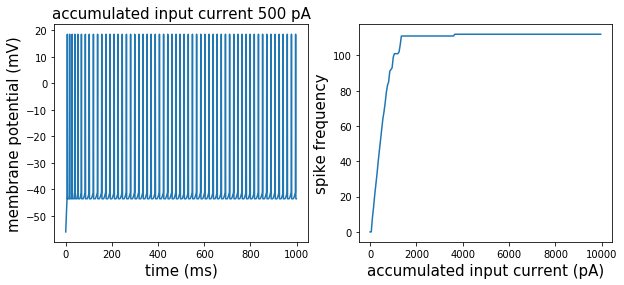

[15, 20]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

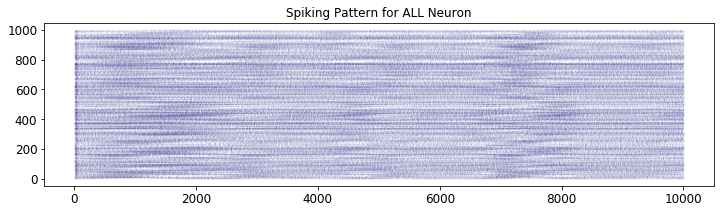

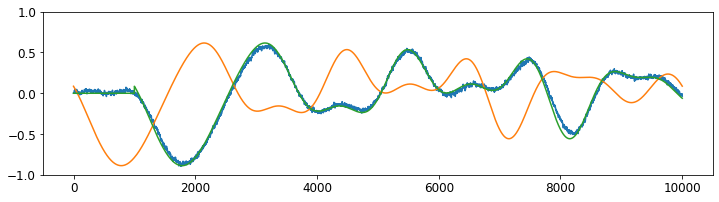

mse and spike frequency for fitted_ALIF 0.00134 12.61
........................................................................


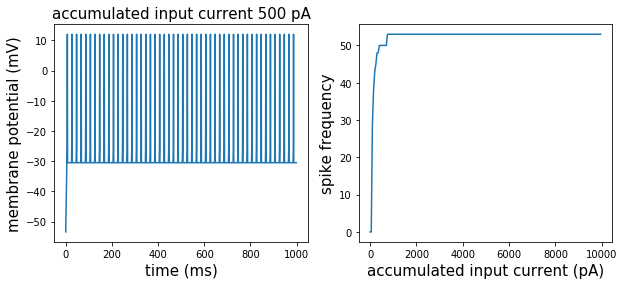

[25, 45]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

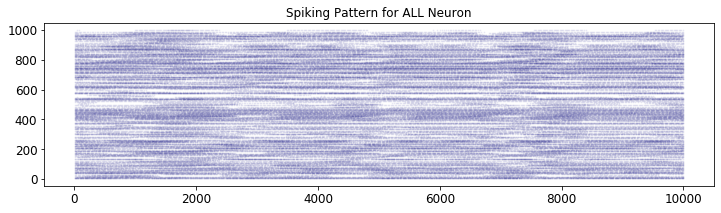

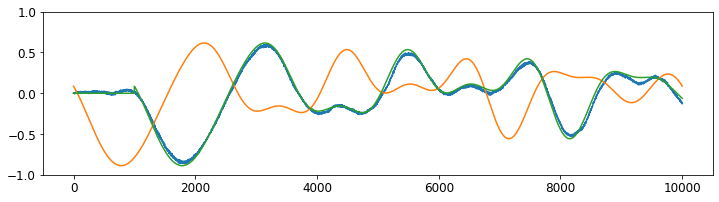

mse and spike frequency for fitted_LIF 0.00144 12.26
........................................................................


In [17]:
############################################################################################
# input frequency 1Hz, 
############################################################################################
seed = 0
dt = 0.001
batch = 1
delay = 1
dim = 6
t_train = 10
t_test = 10
n_in, n_rec, n_out = 1, 1000, 1
tau_recsyn, tau_postsyn = 100, 100
intercept = [-1, 1]
plotFlag = 1
inputFreq = 1

# plot neuron property #####################################
for name in ['fitted_ALIF','fitted_LIF']: 
    neuron_param, ALIF = getParam_multiFit(name)
    propertyList = getProperty(neuron_param, ALIF, 1000, 10, 1) #stimili length(ms), simili intensity(*50pA), plotFlag
    #print("maxFreq at 10nA:",  propertyList[-1])
    rate = [neuron_param[-2], neuron_param[-1]]
    print(rate)
    myLMU = LMU_delay(seed, dt, batch, delay, dim, t_train, t_test, n_in, n_rec, n_out, \
                      tau_recsyn, tau_postsyn, neuron_param, intercept, rate, propertyList, inputFreq, plotFlag)

    mse, avgSpikeFreq = myLMU.delay_functions()
    print("mse and spike frequency for "+name, mse, avgSpikeFreq)
    print("........................................................................")

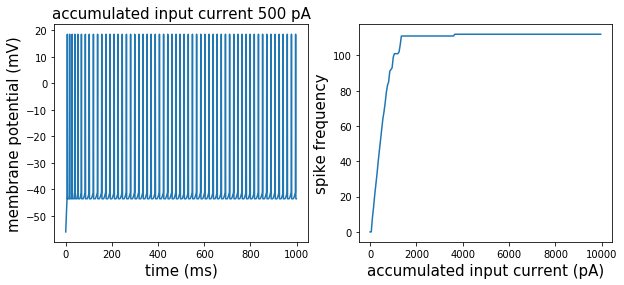

maxFreq at 10nA: 112.0
[15, 20]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

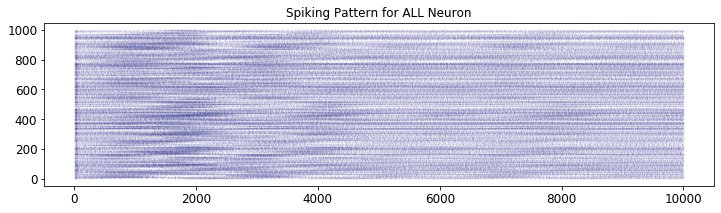

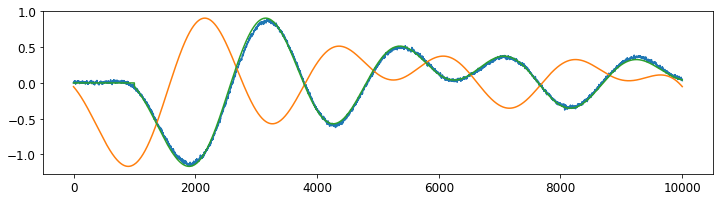

mse and spike frequency for fitted_ALIF 0.00085 13.08


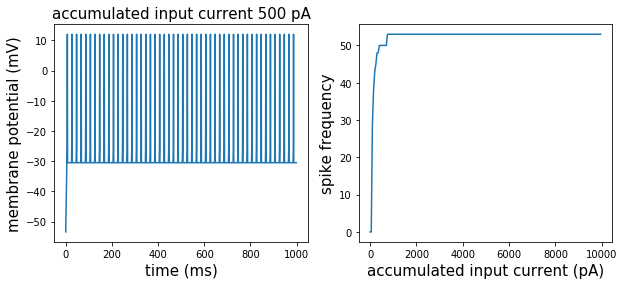

maxFreq at 10nA: 53.0
[25, 45]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

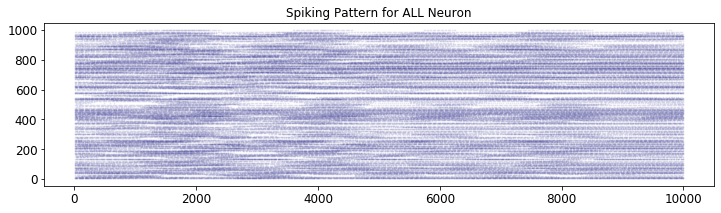

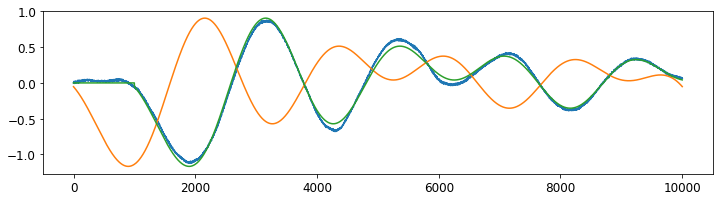

mse and spike frequency for fitted_LIF 0.00204 12.38


In [18]:
############################################################################################
# input frequency 0.5Hz
############################################################################################

seed = 0
dt = 0.001
batch = 1
delay = 1
dim = 6
t_train = 10
t_test = 10
n_in, n_rec, n_out = 1, 1000, 1
tau_recsyn, tau_postsyn = 100, 100
intercept = [-1, 1]
plotFlag = 1
inputFreq = 0.5

# plot neuron property #####################################
for name in ['fitted_ALIF', 'fitted_LIF']: 
    neuron_param, ALIF = getParam_multiFit(name)
    propertyList = getProperty(neuron_param, ALIF, 1000, 10, 1) #stimili length(ms), simili intensity(*50pA), plotFlag
    print("maxFreq at 10nA:",  propertyList[-1])
    rate = [neuron_param[-2], neuron_param[-1]]
    print(rate)

    myLMU = LMU_delay(seed, dt, batch, delay, dim, t_train, t_test, n_in, n_rec, n_out, \
                      tau_recsyn, tau_postsyn, neuron_param, intercept, rate, propertyList, inputFreq, plotFlag)

    mse, avgSpikeFreq = myLMU.delay_functions()
    print("mse and spike frequency for "+name, mse, avgSpikeFreq)

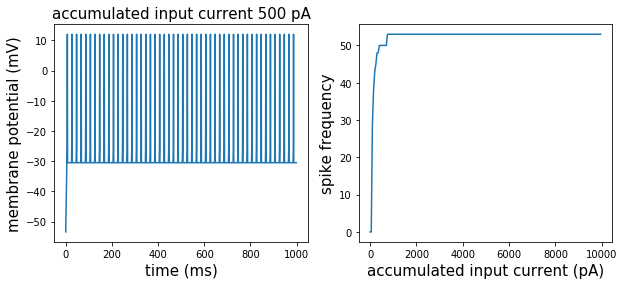

maxFreq at 10nA: 53.0
[25, 45]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

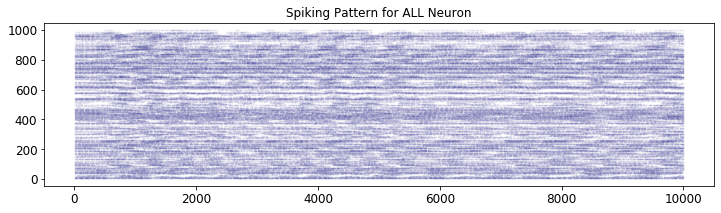

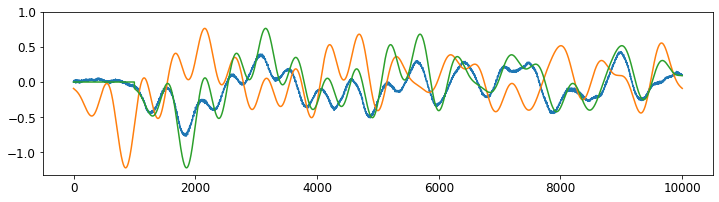

mse and spike frequency for fitted_LIF 0.03703 12.51


In [13]:
############################################################################################
# input frequency 2Hz
############################################################################################

seed = 0
dt = 0.001
batch = 1
delay = 1
dim = 6
t_train = 10
t_test = 10
n_in, n_rec, n_out = 1, 1000, 1
tau_recsyn, tau_postsyn = 100, 100
intercept = [-1, 1]
plotFlag = 1
inputFreq = 2

# plot neuron property #####################################
for name in ['fitted_LIF']:#, 'fitted_LIF']: 
    neuron_param, ALIF = getParam_multiFit(name)
    propertyList = getProperty(neuron_param, ALIF, 1000, 10, 1) #stimili length(ms), simili intensity(*50pA), plotFlag
    print("maxFreq at 10nA:",  propertyList[-1])
    rate = [neuron_param[-2], neuron_param[-1]]
    print(rate)

    myLMU = LMU_delay(seed, dt, batch, delay, dim, t_train, t_test, n_in, n_rec, n_out, \
                      tau_recsyn, tau_postsyn, neuron_param, intercept, rate, propertyList, inputFreq, plotFlag)

    mse, avgSpikeFreq = myLMU.delay_functions()
    print("mse and spike frequency for "+name, mse, avgSpikeFreq)

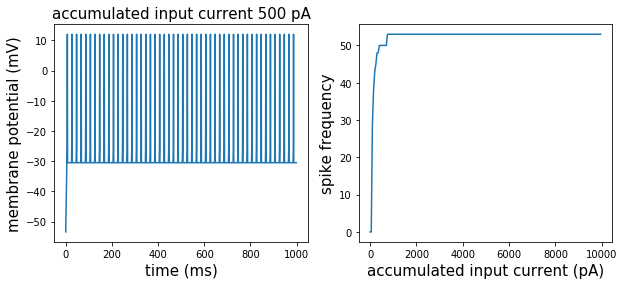

maxFreq at 10nA: 53.0
(25, 45)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

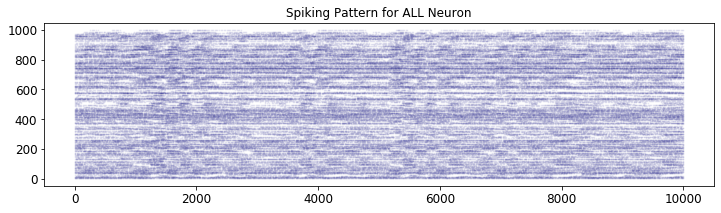

In [ ]:
############################################################################################
# input frequency 3Hz
############################################################################################
seed = 0
dt = 0.001
batch = 1
delay = 1
dim = 6
t_train = 10
t_test = 10
n_in, n_rec, n_out = 1, 1000, 1
tau_recsyn, tau_postsyn = 100, 100
intercept = [-1, 1]
plotFlag = 1
inputFreq = 3

# plot neuron property #####################################
for name in ['fitted_LIF']:#, 'fitted_LIF']: 
    neuron_param, ALIF = getParam_multiFit(name)
    propertyList = getProperty(neuron_param, ALIF, 1000, 10, 1) #stimili length(ms), simili intensity(*50pA), plotFlag
    print("maxFreq at 10nA:",  propertyList[-1])
    rate = neuron_param[-2], neuron_param[-1]
    print(rate)

    myLMU = LMU_delay(seed, dt, batch, delay, dim, t_train, t_test, n_in, n_rec, n_out, \
                      tau_recsyn, tau_postsyn, neuron_param, intercept, rate, propertyList, inputFreq, plotFlag)

    mse, avgSpikeFreq = myLMU.delay_functions()
    print("mse and spike frequency for "+name, mse, avgSpikeFreq)